<a href="https://colab.research.google.com/github/Ashishantal/AshishAntal.github.io/blob/main/Artistic_Style_Transfer_in_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/richzhang/colorization.git
%cd colorization

Cloning into 'colorization'...
remote: Enumerating objects: 4873, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 4873 (delta 125), reused 112 (delta 112), pack-reused 4719 (from 1)
Receiving objects: 100% (4873/4873), 177.90 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (422/422), done.
/content/colorization


In [2]:
import torch
import colorizers

# Load pretrained ECCV16 or SIGGRAPH17 models
colorizer_eccv16 = colorizers.eccv16(pretrained=True).eval()
colorizer_siggraph17 = colorizers.siggraph17(pretrained=True).eval()


Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth" to /root/.cache/torch/hub/checkpoints/colorization_release_v2-9b330a0b.pth


100%|██████████| 123M/123M [00:10<00:00, 12.6MB/s]


Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth" to /root/.cache/torch/hub/checkpoints/siggraph17-df00044c.pth


100%|██████████| 130M/130M [00:10<00:00, 12.8MB/s]


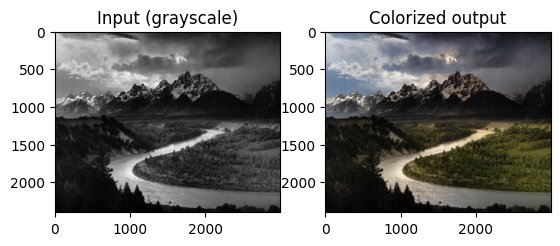

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import skimage.color as color
import torch
import colorizers

# Load pretrained model
colorizer = colorizers.siggraph17(pretrained=True).eval()

# Load grayscale image (convert to RGB so Lab conversion works)
img_path = 'imgs/ansel_adams.jpg'
img = Image.open(img_path).convert("RGB")
img = np.array(img)

# Convert to Lab and extract L channel
img_lab = color.rgb2lab(img)
img_l = img_lab[:,:,0]

# Preprocess: here we pass the numpy array, not the path
tens_l_orig, tens_l_rs = colorizers.preprocess_img(img)

# Run colorizer
out_ab = colorizer(tens_l_rs).cpu()
out_img = colorizers.postprocess_tens(tens_l_orig, out_ab)

# Show results
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Input (grayscale)")

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.title("Colorized output")
plt.show()


In [8]:
import os, io, time
from pathlib import Path
import random
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision import models

import gradio as gr

# make sure python path can import colorizers
import sys
sys.path.append('/content/colorization')   # change if your repo path differs
import colorizers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [9]:
import skimage.color as skcolor
import cv2

# Load pretrained colorizer (siggraph17)
def load_colorizer(which='siggraph17'):
    if which == 'eccv16':
        c = colorizers.eccv16(pretrained=True).to(device).eval()
    else:
        c = colorizers.siggraph17(pretrained=True).to(device).eval()
    return c

colorizer = load_colorizer('siggraph17')

# Helpers to convert back/forth with the colorizer utils
def colorize_with_pretrained(pil_img, colorizer=colorizer, resize_to=256):
    """
    Input: PIL.Image (RGB or L)
    Output: numpy uint8 RGB image (H,W,3)
    """
    # ensure RGB for preprocessing
    pil_rgb = pil_img.convert("RGB")
    np_img = np.array(pil_rgb)
    # preprocess expects numpy array
    tens_l_orig, tens_l_rs = colorizers.preprocess_img(np_img)
    tens_l_rs = tens_l_rs.to(device)
    with torch.no_grad():
        out_ab = colorizer(tens_l_rs).cpu()
    out_img = colorizers.postprocess_tens(tens_l_orig, out_ab)
    # out_img is numpy HxWx3 uint8
    return out_img

# quick display util
def show_pair(p1, p2, titles=('Input','Output')):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(p1); plt.title(titles[0]); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(p2); plt.title(titles[1]); plt.axis('off')
    plt.show()


In [12]:
# VGG feature extractor (use pretrained VGG19)
class VGGFeatures(nn.Module):
    def __init__(self, layers=None):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.vgg = vgg.eval().to(device)
        for p in self.vgg.parameters(): p.requires_grad = False
        # Default layers for style/content per common practice
        self.content_layers = ['21']  # relu4_2
        self.style_layers = ['0','5','10','19','28']  # relu1_1,2_1,3_1,4_1,5_1
    def forward(self, x):
        features = {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.style_layers:
                features[f"style_{name}"] = x
            if name in self.content_layers:
                features[f"content_{name}"] = x
        return features

# image preprocessing for VGG: expects 3xHxW, normalized
vgg_norm_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
vgg_norm_std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

def image_to_vgg_tensor(pil_img, target_size=None):
    img = pil_img.convert("RGB")
    if target_size:
        img = img.resize((target_size, target_size), Image.LANCZOS)
    tf = T.ToTensor()
    t = tf(img).unsqueeze(0).to(device)
    t = (t - vgg_norm_mean) / vgg_norm_std
    return t

def tensor_to_pil(tensor):
    # tensor assumed 1x3xHxW in standard range (denormalized)
    t = tensor.clone().detach().cpu().squeeze(0)
    t = t * vgg_norm_std.cpu().squeeze()[:,None,None] + vgg_norm_mean.cpu().squeeze()[:,None,None]
    t = torch.clamp(t, 0, 1)
    pil = T.ToPILImage()(t)
    return pil

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, h*w)
    G = torch.bmm(features, features.transpose(1,2))
    return G / (ch * h * w)

vgg_feats = VGGFeatures()

def run_style_transfer(content_pil, style_pil,
                       num_steps=200, style_weight=1e6, content_weight=1.0):
    """
    content_pil: PIL image (colorized result)
    style_pil: PIL image (style)
    returns: PIL image result
    """
    # resize style to content size for convenience
    w,h = content_pil.size
    style_p = style_pil.convert("RGB").resize((w,h), Image.LANCZOS)
    content_t = image_to_vgg_tensor(content_pil, target_size=None)
    style_t = image_to_vgg_tensor(style_p, target_size=None)

    # init input as copy of content (commonly faster)
    input_img = content_t.clone().requires_grad_(True).to(device)

    optimizer = optim.LBFGS([input_img], max_iter=20, line_search_fn='strong_wolfe')
    # optionally use Adam (faster per iteration but more iterations)
    # optimizer = optim.Adam([input_img], lr=0.01)

    style_targets = vgg_feats(style_t)
    content_targets = vgg_feats(content_t)
    style_grams = {k: gram_matrix(v) for k,v in style_targets.items()}

    run = [0]
    while run[0] <= num_steps:
        def closure():
            optimizer.zero_grad()
            input_feats = vgg_feats((input_img - vgg_norm_mean) * (1.0 / vgg_norm_std))
            content_loss = 0.0
            style_loss = 0.0
            # content
            for k in content_targets:
                content_loss += torch.nn.functional.mse_loss(input_feats[k], content_targets[k])
            # style
            for k in style_grams:
                G = gram_matrix(input_feats[k.replace('style','style')])
                style_loss += torch.nn.functional.mse_loss(G, style_grams[k])
            loss = content_weight * content_loss + style_weight * style_loss
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0 or run[0] == num_steps:
                print(f"Iteration {run[0]}/{num_steps}, loss: {loss.item():.4e}")
            return loss
        optimizer.step(closure)
        # LBFGS sometimes overshoots; stop if reached
        if run[0] >= num_steps:
            break
    # convert to PIL (denormalize w.r.t vgg norms inside tensor_to_pil)
    result_pil = tensor_to_pil(input_img.detach().cpu())
    return result_pil


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:08<00:00, 71.3MB/s]


In [13]:
from PIL import ImageFilter

def blend_images(base_pil, stylized_pil, strength=0.8):
    """
    Blend between base (colorized) and stylized with 'strength' [0..1].
    strength=0 -> base, strength=1 -> stylized
    """
    return Image.blend(base_pil.convert("RGB"), stylized_pil.convert("RGB"), alpha=float(strength))

def colorize_and_style(pil_input, style_name='van_gogh', style_strength=0.8,
                       iterations=200, style_weight=1e6):
    """
    Full pipeline: take grayscale/RGB PIL input -> colorize -> style transfer -> blend
    returns PIL final image
    """
    # 1) Colorize using pretrained colorizer
    colorized_np = colorize_with_pretrained(pil_input)
    colorized_pil = Image.fromarray(colorized_np)

    # 2) Load style image
    style_path = Path(STYLE_DIR) / f"{style_name}.jpg"
    style_pil = Image.open(style_path).convert("RGB")

    # 3) Run neural style transfer (content = colorized image)
    stylized_pil = run_style_transfer(colorized_pil, style_pil, num_steps=iterations, style_weight=style_weight)

    # 4) Blend according to style_strength
    final = blend_images(colorized_pil, stylized_pil, strength=style_strength)
    return colorized_pil, stylized_pil, final


In [22]:
# Step 1: Colorize
colorized_np = colorize_with_pretrained(pil_in)  # HxWx3 float32, range 0..1

# Convert to uint8 0-255 for PIL
colorized_np_uint8 = (colorized_np * 255).clip(0,255).astype(np.uint8)
colorized_pil = Image.fromarray(colorized_np_uint8)


Saving 8672260.jpg to 8672260 (4).jpg
Iteration 50/300, loss: 4.1297e+02
Iteration 100/300, loss: 1.9694e+02
Iteration 150/300, loss: 1.6165e+02
Iteration 200/300, loss: 1.4985e+02
Iteration 250/300, loss: 1.4398e+02
Iteration 300/300, loss: 1.4050e+02


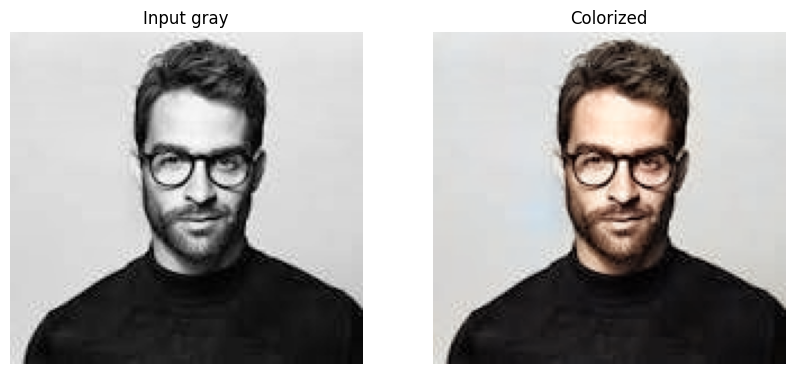

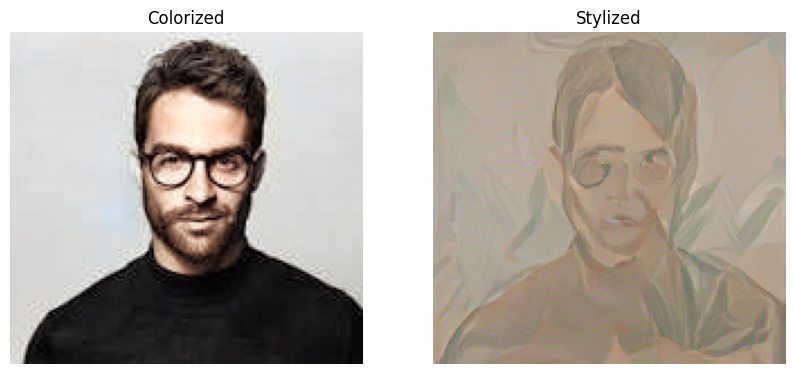

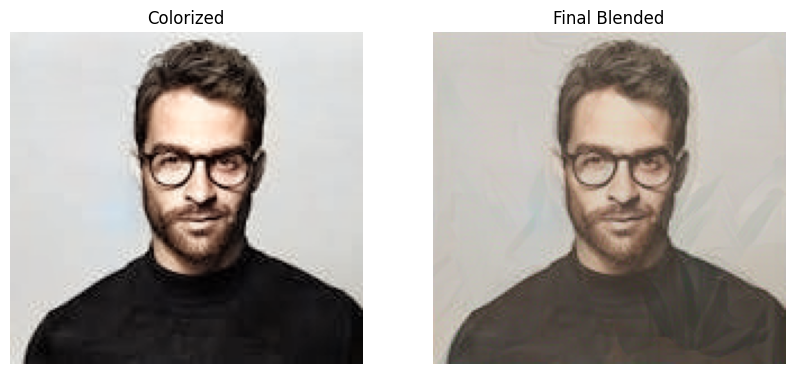

In [33]:
from google.colab import files


# Upload grayscale input + style image(s)
uploaded = files.upload()  # choose gray6.jpg + style image

# Pick grayscale input
gray_filename = "gray6.jpg"  # adjust if needed
style_filename = [f for f in uploaded.keys() if f != gray_filename][0]

# Open images
pil_in = Image.open(gray_filename).convert("L")      # grayscale input
style_pil = Image.open(style_filename).convert("RGB")  # style reference
import cv2
img_gray = np.array(pil_in)
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(5,5))
img_l = clahe.apply(img_gray)
pil_in = Image.fromarray(img_l)

# Step 1: Colorize
colorized_np = colorize_with_pretrained(pil_in)
colorized_np_uint8 = (colorized_np * 255).clip(0,255).astype(np.uint8)
colorized_pil = Image.fromarray(colorized_np_uint8)

# Step 2: Style transfer
stylized_pil = run_style_transfer(
    colorized_pil, style_pil,
    num_steps=300,       # reduce for quick test
    style_weight=1e6
)

# Step 3: Blend
final_pil = blend_images(colorized_pil, stylized_pil, strength=0.4)

# Show results
show_pair(np.array(pil_in.convert("RGB")), colorized_pil, titles=('Input gray','Colorized'))
show_pair(colorized_pil, stylized_pil, titles=('Colorized','Stylized'))
show_pair(colorized_pil, final_pil, titles=('Colorized','Final Blended'))


In [38]:
import gradio as gr
import cv2
import numpy as np
from PIL import Image

# Preprocess grayscale input with CLAHE and resizing
def preprocess_gray(pil_img, resize_to=256):
    pil_img = pil_img.convert("L")
    img = np.array(pil_img)
    # Apply CLAHE for better contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    pil_img = Image.fromarray(img)
    pil_img = pil_img.resize((resize_to, resize_to), Image.LANCZOS)
    return pil_img

# Main pipeline: colorize + optional style transfer + blend
def gradio_pipeline(input_image, style_strength=0.3, iters=250, style_w=1e6, style_upload=None):
    if input_image is None:
        return None, None, None

    # Step 1: preprocess grayscale input
    pil_in = preprocess_gray(input_image, resize_to=256)

    # Step 2: colorize
    colorized_np = colorize_with_pretrained(pil_in)
    colorized_np_uint8 = (colorized_np * 255).clip(0,255).astype(np.uint8)
    colorized_pil = Image.fromarray(colorized_np_uint8)

    # Step 3: handle style
    if style_upload is None:
        # No style uploaded → skip style transfer
        return colorized_pil, None, colorized_pil
    else:
        style_pil = style_upload.convert("RGB").resize(colorized_pil.size, Image.LANCZOS)

    # Step 4: style transfer
    stylized_pil = run_style_transfer(
        colorized_pil,
        style_pil,
        num_steps=int(iters),
        style_weight=float(style_w)
    )

    # Step 5: blend
    final_pil = blend_images(colorized_pil, stylized_pil, strength=style_strength)

    return colorized_pil, stylized_pil, final_pil

# Launch Gradio GUI
demo = gr.Interface(
    fn=gradio_pipeline,
    inputs=[
        gr.Image(type="pil", label="Upload grayscale photo"),
        gr.Slider(0.0, 1.0, value=0.3, step=0.01, label="Style strength (blend)"),
        gr.Number(value=250, label="Style iterations (higher=better)"),
        gr.Number(value=1e6, label="Style weight"),
        gr.Image(type="pil", label="Upload custom style (optional)")
    ],
    outputs=[
        gr.Image(type="pil", label="Colorized"),
        gr.Image(type="pil", label="Stylized"),
        gr.Image(type="pil", label="Final blended")
    ],
    title="Colorize + Artistic Style",
    description="Upload a grayscale photo and optionally a style image to colorize and apply artistic style."
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f2b26b6f027de94003.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
